In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-dataset/train_E6oV3lV.csv


In [2]:
!pip install pandas_profiling 

In [3]:
import pandas_profiling
import nltk
import numpy as np
import cudf as pd
import pandas
import re
import matplotlib.pyplot as plt 
import seaborn as sb
from nltk.corpus import stopwords
import warnings 
warnings.filterwarnings("ignore") #to ignore warnings 
import unidecode #takes Unicode data and tries to represent it in ASCII characters
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk.stem import PorterStemmer
nltk.download('punkt') #sentence tokenizer 
from nltk.tokenize import word_tokenize 
import matplotlib.animation as animation
import operator #imports efficient functions corresponding to intrinsic operator in python 
import plotly.express as px #high level wrapper for plotly. in other words plotly with simpler syntax 
%matplotlib inline

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
df=pd.read_csv('../input/twitter-dataset/train_E6oV3lV.csv')

In [5]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
df['tweet'][0]

' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'

***Removing duplicates and missing values***

In [7]:
df.drop_duplicates(inplace=True)#inplace=True modifies the original dataset instead of returning a new one 

In [8]:
df['label'].isna().sum()

0

In [9]:
df['tweet'].isna().sum()

0

In [10]:
df.head(10)

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


***Removing special characters and linguistic inconsistencies***

In [11]:
#removing @
# if isinstance(pd.DataFrame):
df=df.to_pandas()
for i, tweet in enumerate(df['tweet']):
    lst=tweet.split()
    lst = [i for i in lst if not i.startswith('@')]
    lst=' '.join(lst)
    df['tweet'][i]=lst

In [12]:
df['tweet'][10]

'â\x86\x9d #ireland consumer price index (mom) climbed from previous 0.2% to 0.5% in may #blog #silver #gold #forex'

In [13]:
for i, tweet in enumerate(df['tweet']):
    lst=tweet.split()
    lst = [i for i in lst if not i.isdigit()]
    lst=' '.join(lst)
    df['tweet'][i]=lst

In [14]:
df['tweet'][5461]

"now a year old is dead because his parents didn't have common sense"

In [15]:
#Removing the word 'hmm' and it's variants
import re
df['clean_tweet'] = df['tweet'].apply(lambda x : ' '.join([word for word in x.split() if not len(re.findall('h(m)+',word))]))

In [16]:
df['clean_tweet'][5416]

'for does this go under #funny, , or #women today?'

In [17]:
#Code for removing slang words
d = {'luv':'love','wud':'would','lyk':'like','wateva':'whatever','ttyl':'talk to you later',
               'kul':'cool','fyn':'fine','omg':'oh my god!','fam':'family','bruh':'brother',
               'cud':'could','fud':'food'}

In [18]:
df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join(d[word] if word in d else word for word in x.split()))

In [19]:
df['clean_tweet'][26605]

"father's love knows no boundaries as it grows healthier each day... father's day"

In [20]:
pip install unidecode 

Note: you may need to restart the kernel to use updated packages.


In [21]:
#Removing all the greek characters using unidecode library
df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join([unidecode.unidecode(word) for word in x.split()])) 

In [22]:
df['clean_tweet'][7]

"the next school year is the year for exams.d- can't think about that d #school #exams #hate #imagine #actorslife #revolutionschool #girl"

In [23]:
#Finding words with '#' 
df['hash']=df['clean_tweet'].apply(lambda x:' '.join([word for word in x.split() if word.startswith('#')]))

In [24]:
df.head()

,id,label,tweet,clean_tweet,hash
0,1,0,when a father is dysfunctional and is so selfi...,when a father is dysfunctional and is so selfi...,#run
1,2,0,thanks for #lyft credit i can't use cause they...,thanks for #lyft credit i can't use cause they...,#lyft #disapointed #getthanked
2,3,0,bihday your majesty,bihday your majesty,
3,4,0,#model i love u take with u all the time in ur...,#model i love u take with u all the time in ur...,#model
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation,#motivation


In [25]:
for i, hashtag in enumerate(df['hash']):
    if hashtag == '':
        df['hash'][i]='no hashtag'

In [26]:
df.head(10)

,id,label,tweet,clean_tweet,hash
0,1,0,when a father is dysfunctional and is so selfi...,when a father is dysfunctional and is so selfi...,#run
1,2,0,thanks for #lyft credit i can't use cause they...,thanks for #lyft credit i can't use cause they...,#lyft #disapointed #getthanked
2,3,0,bihday your majesty,bihday your majesty,no hashtag
3,4,0,#model i love u take with u all the time in ur...,#model i love u take with u all the time in ur...,#model
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation,#motivation
5,6,0,[2/2] huge fan fare and big talking before the...,[2/2] huge fan fare and big talking before the...,#allshowandnogo
6,7,0,camping tomorrow dannyâ¦,camping tomorrow dannya|,no hashtag
7,8,0,the next school year is the year for exams.ð...,the next school year is the year for exams.d- ...,#school #exams #hate #imagine #actorslife #rev...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...,we won!!! love the land!!! #allin #cavs #champ...,#allin #cavs #champions #cleveland #clevelandc...
9,10,0,welcome here ! i'm it's so #gr8 !,welcome here ! i'm it's so #gr8 !,#gr8


In [27]:
#remove stopwords
df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join([word for word in x.split() if not word in set(stopwords.words('english'))]))

In [28]:
dataframe=df.copy(deep=True)

In [29]:
#Lemmitization
lemmatizer = WordNetLemmatizer()
df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [30]:
df.compare(dataframe)

clean_tweet  \
                                                    self   
0      father dysfunctional selfish drag kid dysfunct...   
1      thanks #lyft credit can't use cause offer whee...   
5      [2/2] huge fan fare big talking leave. chaos p...   
13     #cnn call #michigan middle school 'build wall'...   
18     #friday! smile around via ig user: #cookies ma...   
...                                                  ...   
31950  try 'tail' u stop, 'butt' we're good time! #go...   
31955  le week dd 1/4 d1ddu #ibiza#bringiton#mallorca...   
31956        fishing tomorrow carnt wait first time year   
31958  see nina turner airwave trying wrap mantle gen...   
31959     listening sad song monday morning otw work sad   

                                                          
                                                   other  
0      father dysfunctional selfish drags kids dysfun...  
1      thanks #lyft credit can't use cause offer whee...  
5      [2/2] huge fan fare big talking leave. chaos p...  
13     #cnn calls #michigan middle school 'build wall...  
18     #friday! smiles around via ig user: #cookies m...  
...                                                  ...  
31950  try 'tail' us stop, 'butt' we're good time! #g...  
31955  less weeks dd 1/4 d1ddu #ibiza#bringiton#mallo...  
31956       fishing tomorrow carnt wait first time years  
31958  see nina turner airwaves trying wrap mantle ge...  
31959    listening sad songs monday morning otw work sad  

[9708 rows x 2 columns]

In [31]:
dataframe['clean_tweet'][0]

'father dysfunctional selfish drags kids dysfunction. #run'

In [32]:
df['clean_tweet'][0]

'father dysfunctional selfish drag kid dysfunction. #run'

In [33]:
#Stemming
ps = PorterStemmer()
df['clean_tweet'] = df['clean_tweet'].apply(lambda x : ' '.join([ps.stem(word) for word in x.split()]))

In [34]:
df['clean_tweet'][0]

'father dysfunct selfish drag kid dysfunction. #run'

In [35]:
corpus = df['clean_tweet'].to_list()

In [36]:
corpus 

['father dysfunct selfish drag kid dysfunction. #run',
 "thank #lyft credit can't use caus offer wheelchair van pdx. #disapoint #getthank",
 'bihday majesti',
 '#model love u take u time urd+-!!! dddd d|d|d|',
 'factsguide: societi #motiv',
 '[2/2] huge fan fare big talk leave. chao pay disput get there. #allshowandnogo',
 'camp tomorrow dannya|',
 "next school year year exams.d- can't think #school #exam #hate #imagin #actorslif #revolutionschool #girl",
 'won!!! love land!!! #allin #cav #champion #cleveland #clevelandcavali a|',
 "welcom ! i'm #gr8 !",
 '#ireland consum price index (mom) climb previou 0.2% 0.5% may #blog #silver #gold #forex',
 'selfish. #orlando #standwithorlando #pulseshoot #orlandoshoot #biggerproblem #selfish #heabreak #valu #love #',
 'get see daddi today!! #80day #gettingf',
 "#cnn call #michigan middl school 'build wall' chant '' #tcot",
 'comment! #australia #opkillingbay #seashepherd #helpcovedolphin #thecov #helpcovedolphin',
 'ouch...junior angryd#got7 #ju

In [37]:
!pip install wordcloud

(-0.5, 799.5, 499.5, -0.5)

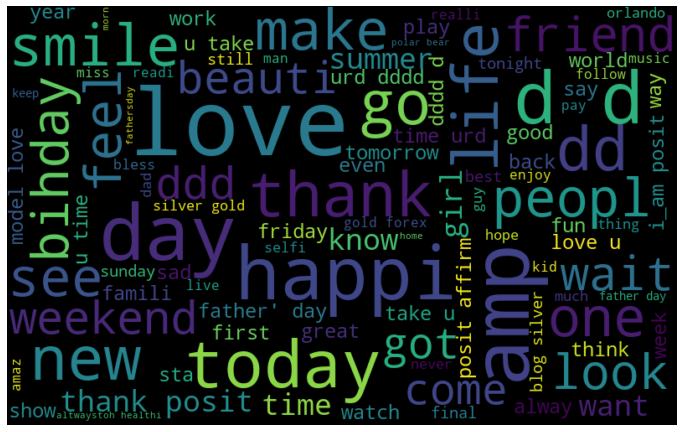

In [38]:
normal_words = ' '.join([tweet for tweet in df['clean_tweet'][df['label'] == 0]])
wordcloud = WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 100).generate(normal_words)
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
plt.axis('off')

In [39]:
# normalwords=[]
# for i, tweet in enumerate(df['clean_tweet']):
#     if df['label'][i]==0:
#         normalwords.append(tweet)
# ' '.join(normalwords)

(-0.5, 799.5, 499.5, -0.5)

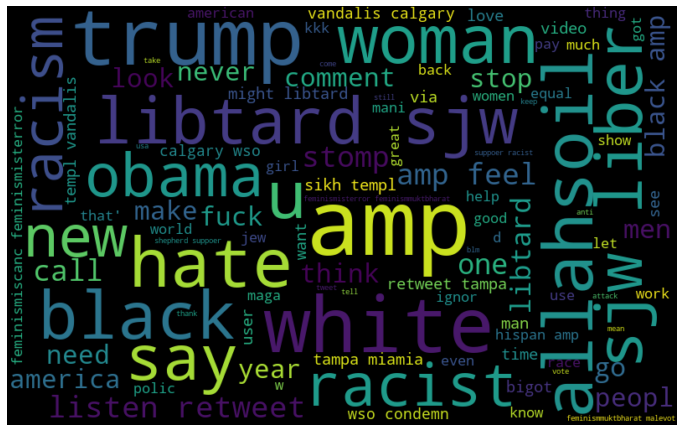

In [40]:
normalwords=''.join(tweet for tweet in df['clean_tweet'][df['label']==1])
wordcloud=WordCloud(width = 800, height = 500, max_font_size = 110,max_words = 100).generate(normalwords)
plt.figure(figsize= (12,8))
plt.imshow(wordcloud, interpolation = 'bilinear',cmap='viridis')
plt.axis('off')

In [41]:
#Collecting positive hashtags
hash_positive = []
hash_negative = []

In [42]:
def hashtag_extract(tweets):
    hashtags = []
    # Loop over the words in the tweet
    for tweet in tweets:
        ht = re.findall(r"#(\w+)", tweet) #ht is a list of all the hashtags in tweet 
        hashtags.append(ht)

    return hashtags #hashtags is a list of ht's which too are lists. so a list of lists 

In [43]:
#extracting hashtags from non-hate tweets
hash_positive = hashtag_extract(df['clean_tweet'][df['label'] == 0])

# extracting hashtags from racist/sexist tweets
hash_negative = hashtag_extract(df['clean_tweet'][df['label'] == 1])

In [44]:
# Converting a multidimensional list to a 1-D list
hash_positive = sum(hash_positive,[]) #sum function will turn hash_positive to a 1D list 
hash_negative = sum(hash_negative,[])

In [45]:
from collections import Counter

In [46]:
freq_positive = Counter(hash_positive) #Counter class creates a hashtable of an iterable 
freq_positive = dict(freq_positive.most_common()) #ordered in order of the highest frequencies using most_common()

In [47]:
values_positive=list(freq_positive.values()) #list of frequency value for each hashtag key
values_positive[:5]

[1579, 905, 636, 558, 526]

In [48]:
key_positive=list(freq_positive.keys())
key_positive[:5]

['love', 'posit', 'smile', 'healthi', 'thank']

In [49]:
freq_negative = Counter(hash_negative) #Counter class creates a hashtable of an iterable 
freq_negative = dict(freq_negative.most_common()) #ordered in order of the highest frequencies using most_common()

In [50]:
values_negative=list(freq_negative.values()) #list of frequency value for each hashtag key
values_negative[:5]

[133, 94, 92, 79, 77]

In [51]:
key_negative=list(freq_negative.keys())
key_negative[:5]

['trump', 'polit', 'allahsoil', 'liber', 'libtard']

In [52]:
hashone=pd.DataFrame(key_positive,columns=['Positive_words'])
hashtwo=pd.DataFrame(values_positive,columns=['Positive_count'])
hashthree=pd.DataFrame(key_negative,columns=['Negative_words'])
hashfour=pd.DataFrame(values_negative,columns=['Negative_count'])

In [53]:
hashwords=pd.concat([hashone, hashtwo, hashthree, hashfour], axis=1)

In [54]:
hashwords.head()

,Positive_words,Positive_count,Negative_words,Negative_count
0,love,1579,trump,133
1,posit,905,polit,94
2,smile,636,allahsoil,92
3,healthi,558,liber,79
4,thank,526,libtard,77


In [55]:
df.head()

,id,label,tweet,clean_tweet,hash
0,1,0,when a father is dysfunctional and is so selfi...,father dysfunct selfish drag kid dysfunction. ...,#run
1,2,0,thanks for #lyft credit i can't use cause they...,thank #lyft credit can't use caus offer wheelc...,#lyft #disapointed #getthanked
2,3,0,bihday your majesty,bihday majesti,no hashtag
3,4,0,#model i love u take with u all the time in ur...,#model love u take u time urd+-!!! dddd d|d|d|,#model
4,5,0,factsguide: society now #motivation,factsguide: societi #motiv,#motivation


In [56]:
#Techniques to convert the tweets into Bag-of-Words, TF-IDF
#Building various classifiers: -
#TF-IDF approach
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2,stop_words='english')
# TF-IDF feature matrix
X1 = tfidf_vectorizer.fit_transform(corpus).toarray()
Y1 = df.loc[:,'label'].values

In [57]:
Y1.shape

(31962,)

In [58]:
from sklearn.model_selection import train_test_split
X1_train, X1_test, Y1_train, Y1_test = train_test_split(df['clean_tweet'], df['label'], test_size = 0.3, random_state=0, shuffle = True, stratify=df['label'])
vectorizer = TfidfVectorizer()
X1_train_vect = vectorizer.fit_transform(X1_train)
Y1 = df.loc[:,'label'].values

In [59]:
X1_train

17967                       new spectacl readi collection.
20493    waahey reunit two amaz souls. blessed. #friend...
12675                    mighti eagl falling.. . #ripamodu
30618    #beach day like roll around sand like bum get ...
28794    make everyday count dd- toward healthi life d-...
                               ...                        
7593     option read park #ghostbust day dd3d #comic #f...
25950                         founate.#i_am #posit #affirm
2155       might libtard if... #libtard #sjw #liber #polit
9363                            long #avivatw2016 dud'dud'
26846             latest "say what?!?!" thank #culturesway
Name: clean_tweet, Length: 22373, dtype: object

In [60]:
X1_train_vect

<22373x31095 sparse matrix of type '<class 'numpy.float64'>'
	with 175429 stored elements in Compressed Sparse Row format>

In [61]:
#Random Forest using pipelines
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
rf = Pipeline([('tfidf', TfidfVectorizer()), ('rf', RandomForestClassifier())])
rf.fit(X1_train, Y1_train)
y_pred = rf.predict(X1_test)
print(pandas.crosstab(Y1_test,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(Y1_test, y_pred))

Predicted     0    1
Actual              
0          8892   24
1           348  325
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      8916
           1       0.93      0.48      0.64       673

    accuracy                           0.96      9589
   macro avg       0.95      0.74      0.81      9589
weighted avg       0.96      0.96      0.96      9589



In [62]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(Y1_test, y_pred))

0.7401102713988309


In [63]:
from sklearn.linear_model import LogisticRegression
clf = Pipeline([('tfidf', TfidfVectorizer()), ('lr', LogisticRegression())])
clf.fit(X1_train, Y1_train)
y_pred = clf.predict(X1_test)
print(pandas.crosstab(Y1_test,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(Y1_test, y_pred))

Predicted     0    1
Actual              
0          8901   15
1           472  201
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      8916
           1       0.93      0.30      0.45       673

    accuracy                           0.95      9589
   macro avg       0.94      0.65      0.71      9589
weighted avg       0.95      0.95      0.94      9589



In [64]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(Y1_test, y_pred))

0.6484901677669143


In [66]:
from sklearn.naive_bayes import MultinomialNB
nav = Pipeline([('tfidf', TfidfVectorizer()), ('nv', MultinomialNB())])
nav.fit(X1_train, Y1_train)
y_pred = nav.predict(X1_test)
print(pandas.crosstab(Y1_test,y_pred,rownames=['Actual'],colnames=['Predicted']))
print(classification_report(Y1_test, y_pred))

Predicted     0    1
Actual              
0          8916    0
1           573  100
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8916
           1       1.00      0.15      0.26       673

    accuracy                           0.94      9589
   macro avg       0.97      0.57      0.61      9589
weighted avg       0.94      0.94      0.92      9589



In [67]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(Y1_test, y_pred))

0.5742942050520059
